In [41]:
    
import nltk
from nltk.corpus import stopwords
import re
import requests
import json
import pandas as pd
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import graphviz
import numpy as np

In [2]:
all_news_data = []
file_name_news = 'exam_newsapidata.csv'
newscolumns = ['source','description','title','content','url']
topics = ["politics", "analytics", "business", "sports"]

In [3]:
def cleandescription(description):
    description = str(description)
    description = re.sub(r'[,.;@#?!&$\-\']+', ' ', description, flags=re.IGNORECASE)
    description = re.sub(' +', ' ', description, flags=re.IGNORECASE)
    description = re.sub(r'\"', ' ', description, flags=re.IGNORECASE)
    description = re.sub(r'[^a-zA-Z]', " ", description, flags=re.VERBOSE)
    description = description.replace(',', '')
    description = ' '.join(description.split())
    description = re.sub("\n|\r", "", description)
    description = ' '.join([wd for wd in description.split() if len(wd)>3])
    return description

In [4]:
def cleanTitle(Title):
    Title = str(Title)
    Title = re.sub(r'[,.;@#?!&$\-\']+', ' ', str(Title), flags=re.IGNORECASE)
    Title = re.sub(' +', ' ', str(Title), flags=re.IGNORECASE)
    Title = re.sub(r'\"', ' ', str(Title), flags=re.IGNORECASE)
    Title = re.sub(r'[^a-zA-Z]', " ", str(Title), flags=re.VERBOSE)
    Title = Title.replace(',', '')
    Title = ' '.join(Title.split())
    Title = re.sub("\n|\r", "", Title)
    return Title

In [5]:
def getDate(Date):
    NewDate = Date.split("T")
    Date = NewDate[0]
    return Date

In [6]:
def getdatafromnewApi():
    url = 'https://newsapi.org/v2/everything'
    apiKey = '120b448077954edebc2caa99382602cb'
    
    MyFILE=open(file_name_news, "a")
    WriteThis = 'LABEL,Date,Source,Title,Description\n'
    MyFILE.write(WriteThis)
    for topic in topics:
        try:
            params = {'q': topic, 
                    'apikey': apiKey}
            response = requests.get(url, params=params)  
            if response.status_code == 200:
                text_value = json.loads(response.text)
                all_articles = text_value['articles']
                for i in range(len(all_articles)):
                    movie_details = {}
                    if 'source' in all_articles[i]:
                        source = all_articles[i]["source"]["name"]
                    if 'description' in all_articles[i]:
                        filtered_description = cleandescription(all_articles[i]['description'])
                    if 'title' in all_articles[i]:
                        filtered_title = cleanTitle(all_articles[i]['title'])
                    if 'publishedAt' in all_articles[i]:
                        filtered_date = getDate(all_articles[i]['publishedAt'])
                    if 'content' in all_articles[i]:
                        movie_details['content'] = all_articles[i]['content']
                    WriteThis = str(topic)+","+str(filtered_date)+","+str(source)+","+ str(filtered_title) + "," + str(filtered_description) + "\n"   
                    MyFILE.write(WriteThis)                  
        except Exception as exp:
            print(f"error while hitting the news api",{exp})  
    MyFILE.close()

In [7]:
getdatafromnewApi()

In [8]:
BBC_DF = pd.read_csv(file_name_news, error_bad_lines=False)
BBC_DF = BBC_DF.dropna()
HeadlineLIST = []
LabelLIST = []

/var/folders/v0/c09mhxm16tbfpb_vs2y35r_m0000gn/T/ipykernel_37350/1164226729.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  BBC_DF = pd.read_csv(file_name_news, error_bad_lines=False)


/Users/karandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


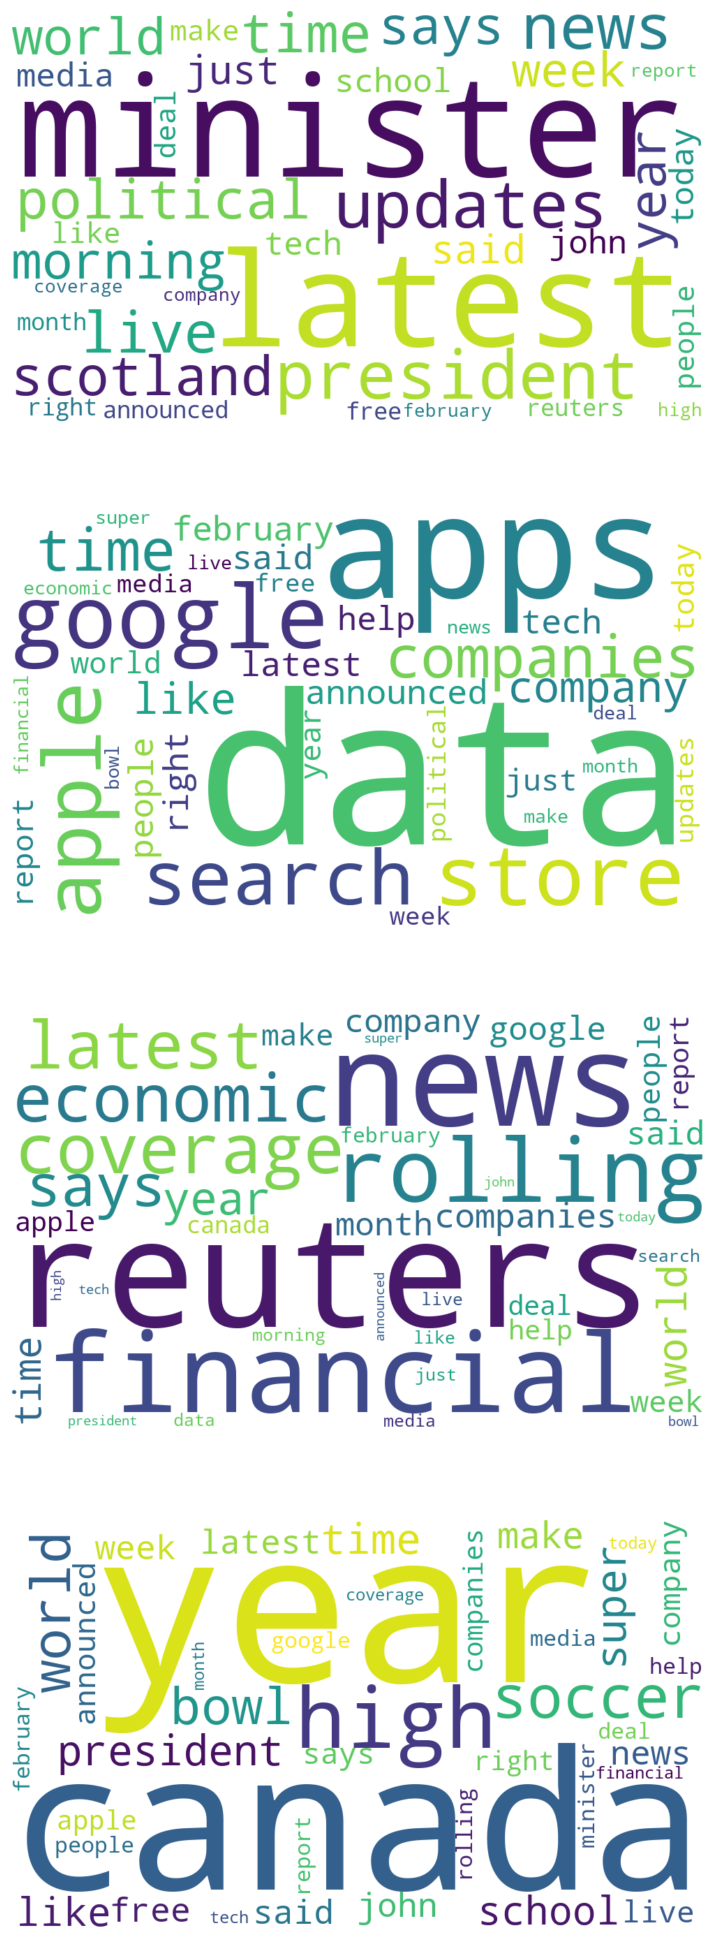

In [9]:
for nexthead, nextlabel in zip(BBC_DF["Description"], BBC_DF["LABEL"]):
    HeadlineLIST.append(nexthead)
    LabelLIST.append(nextlabel)

NewHeadlineLIST=[]
for element in HeadlineLIST:
    AllWords = element.split(" ")
    #print(AllWords)
    NewWordsList=[]
    for word in AllWords:
        word = word.lower()
        if word in topics:
            continue
        else:
            NewWordsList.append(word)
    NewWords = " ".join(NewWordsList)
    NewHeadlineLIST.append(NewWords)

HeadlineLIST = NewHeadlineLIST
MyCountV = CountVectorizer(
        input="content",  ## because we have a csv file
        lowercase=True, 
        stop_words = "english",
        max_features=50
    )
MyDTM = MyCountV.fit_transform(HeadlineLIST) 
ColumnNames = MyCountV.get_feature_names()
MyDTM_DF = pd.DataFrame(MyDTM.toarray(),columns=ColumnNames)
Labels_DF = DataFrame(LabelLIST,columns=['LABEL'])
My_Orig_DF = MyDTM_DF
dfs = [Labels_DF, MyDTM_DF]
Final_News_DF_Labeled = pd.concat(dfs,axis=1, join='inner')  

List_of_WC=[]

for mytopic in topics:

    tempdf = Final_News_DF_Labeled[Final_News_DF_Labeled['LABEL'] == mytopic]    
    tempdf =tempdf.sum(axis=0,numeric_only=True)
    NextVarName=str("wc"+str(mytopic))
    NextVarName = WordCloud(width=1000, height=600, background_color="white",
                   min_word_length=4,
                   max_words=200).generate_from_frequencies(tempdf)
    List_of_WC.append(NextVarName)

fig = plt.figure(figsize=(25, 25))
NumTopics = len(topics)
for i in range(NumTopics):
    ax = fig.add_subplot(NumTopics,1,i+1)
    plt.imshow(List_of_WC[i], interpolation='bilinear')
    plt.axis("off")
    plt.savefig("NewClouds.pdf")


[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
Silhouette Score for k = 3 
 0.42460142181854615
[[0.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.11022302e-16 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 2.22044605e-16 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 ...
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.11022302e-16
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 2.22044605e-16]]
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
[[0.00000000e+00 7.90000000e+01 0.00000000e+00 2.00000000e+00]
 [1.00000000e+00 4.02000000e+02 0.00000000e+00 2.00000000e+00]
 [2.00000000e+00 3.00000000e+00 0

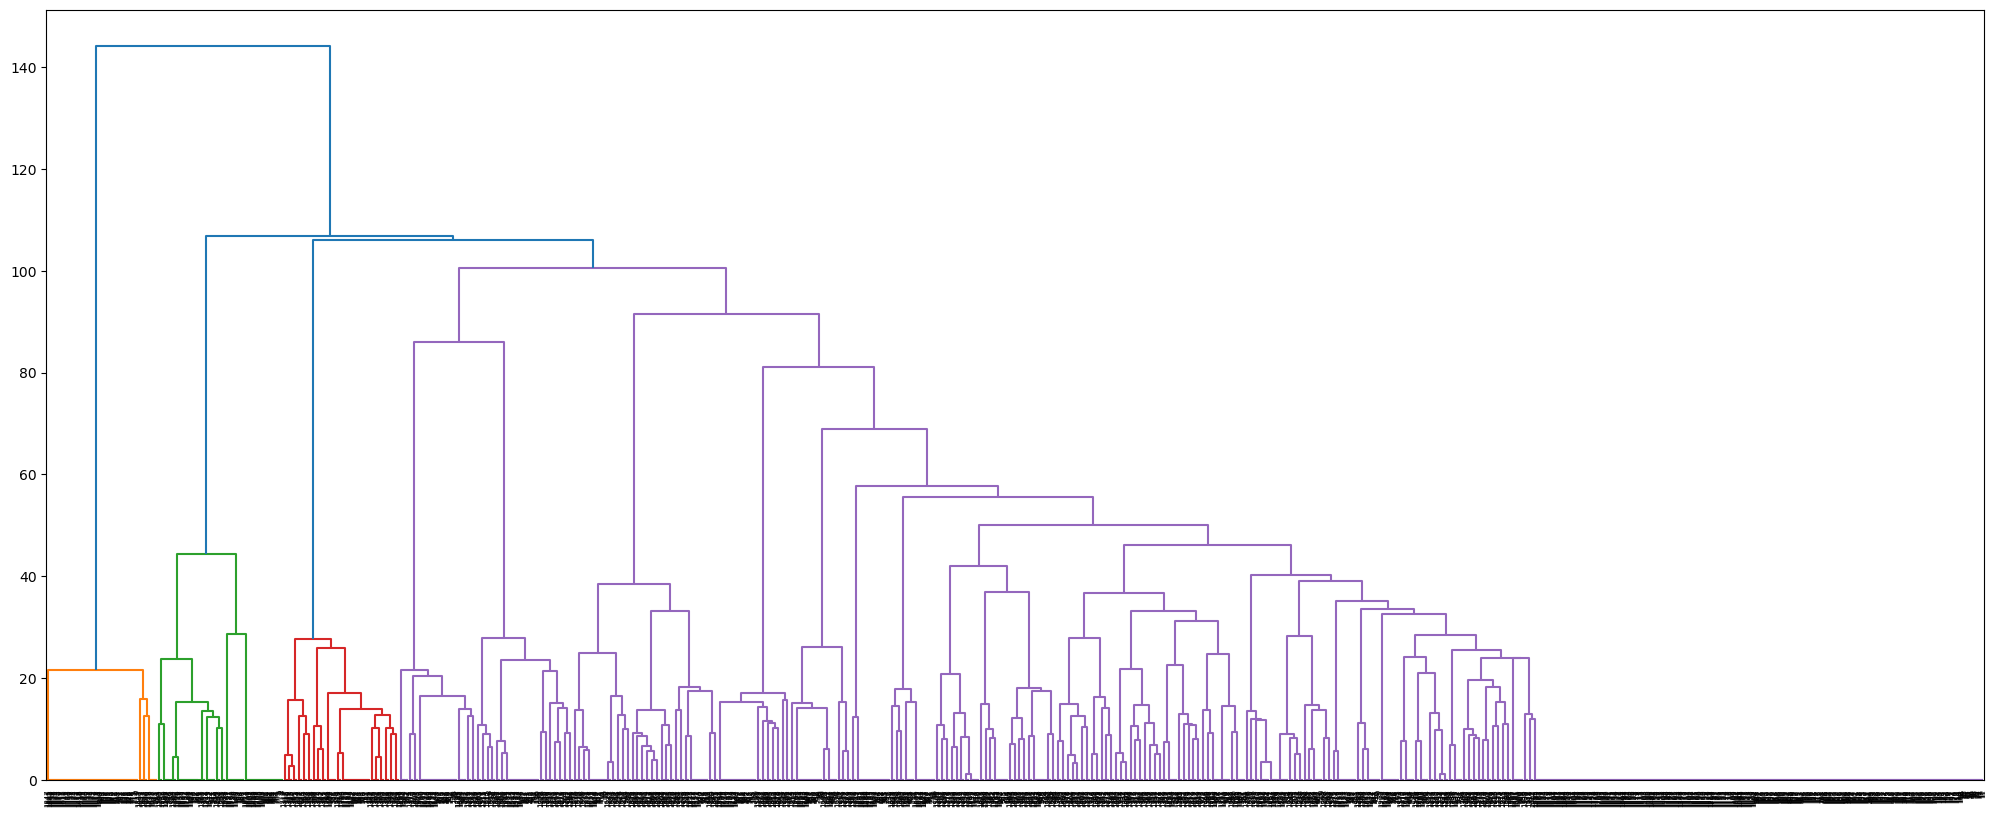

In [10]:
My_KMean = KMeans(n_clusters=3)
My_KMean.fit(My_Orig_DF)
My_labels = My_KMean.predict(My_Orig_DF)
print(My_labels)   

My_KMean2 = KMeans(n_clusters=4).fit(preprocessing.normalize(My_Orig_DF))
My_KMean2.fit(My_Orig_DF)
My_labels2=My_KMean2.predict(My_Orig_DF)
print(My_labels2)

My_KMean3= KMeans(n_clusters=3)
My_KMean3.fit(My_Orig_DF)
My_labels3=My_KMean3.predict(My_Orig_DF)
print("Silhouette Score for k = 3 \n",silhouette_score(My_Orig_DF, My_labels3))

cosdist = 1 - cosine_similarity(MyDTM)
print(cosdist)
print(np.round(cosdist,3))


linkage_matrix = ward(cosdist)  
print(linkage_matrix)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_matrix)
plt.show()

In [35]:

Final_News_DF_Labeled.to_csv("Labeled_News_Data_from_API.csv")
TrainDF, TestDF = train_test_split(Final_News_DF_Labeled, test_size=0.3)
### TEST----------------------
TestLabels = TestDF["LABEL"]
TestDF = TestDF.drop(["LABEL"], axis=1)
### TRAIN----------------------
TrainLabels = TrainDF["LABEL"]
TrainDF = TrainDF.drop(["LABEL"], axis=1)
topics.append("LABEL")


In [36]:

##################################################
## STEP 3:  Run MNB
##################################################

## Instantiate
MyModelNB = MultinomialNB()

## FIT
MyNB = MyModelNB.fit(TrainDF, TrainLabels)
Prediction = MyModelNB.predict(TestDF)
print(np.round(MyModelNB.predict_proba(TestDF),2))

## COnfusion Matrix Accuracies
cnf_matrix = confusion_matrix(TestLabels, Prediction)
print("\nThe confusion matrix is:")
print(cnf_matrix)


[[0.   0.25 0.25 0.25 0.24]
 [0.   0.16 0.24 0.56 0.03]
 [0.   0.   0.01 0.09 0.91]
 ...
 [0.   0.88 0.11 0.   0.01]
 [0.   0.25 0.25 0.25 0.24]
 [0.   0.14 0.39 0.04 0.42]]

The confusion matrix is:
[[ 0  0  2  0  0]
 [ 0 75 48 13 11]
 [ 0 18 97 18 10]
 [ 0  3 47 84 15]
 [ 0 12 47 51 51]]


In [38]:
##################################################
## STEP 3:  Run DT
##################################################

## Instantiate
MyDT = DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                            splitter='best',  ## or "random" or "best"
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0,  
                            class_weight=None)

MyDT.fit(TrainDF, TrainLabels)


feature_names=TrainDF.columns

Tree_Object = tree.export_graphviz(MyDT, out_file=None,
                      feature_names=feature_names,  
                      class_names=topics,  
                      filled=True, rounded=True,  
                      special_characters=True)      
                              
graph = graphviz.Source(Tree_Object) 
    
graph.render("MyTree") 


## COnfusion Matrix
print("Prediction\n")
print(TestDF)
DT_pred=MyDT.predict(TestDF)
print(DT_pred)
print(TestLabels)
    
bn_matrix = confusion_matrix(TestLabels, DT_pred)
print("\nThe confusion matrix is:")
print(bn_matrix)


Prediction

      announced  apple  apps  bowl  canada  companies  company  coverage  \
1350          0      0     0     0       0          0        0         0   
944           0      0     0     0       0          0        0         0   
417           0      0     0     0       0          0        0         0   
289           0      0     0     0       0          0        0         0   
1450          0      0     0     0       0          0        1         0   
...         ...    ...   ...   ...     ...        ...      ...       ...   
481           0      0     0     0       0          0        0         0   
294           0      0     0     0       0          0        0         0   
1801          0      0     0     0       0          0        0         0   
754           0      0     0     0       0          0        0         0   
1156          0      0     0     0       0          0        1         0   

      data  deal  ...  soccer  store  super  tech  time  today  updates  we

(2004, 5)
LDA Model:
Topic 0:
[('says', 111.88098037842225), ('said', 105.5336960578192), ('minister', 93.64554776084088), ('john', 50.153322798565455), ('tech', 49.51518328738985), ('store', 48.985843977785265), ('scotland', 43.85948361720464), ('apple', 18.178490230726766), ('help', 15.432265090394191), ('announced', 10.607238840001555)]
Topic 1:
[('time', 104.05442793820119), ('like', 87.15592669420238), ('company', 80.67760947732356), ('canada', 79.79629390579497), ('make', 76.31468572598591), ('soccer', 59.078405493933865), ('apps', 58.725134699547205), ('media', 50.08573847520173), ('apple', 48.518464876377664), ('announced', 45.70793099971386)]
Topic 2:
[('year', 165.69097502338806), ('reuters', 112.68101036283954), ('world', 101.53896403575084), ('week', 95.66750626869894), ('people', 69.68819967828922), ('high', 68.8526361992478), ('school', 56.74473201186287), ('bowl', 52.52246768461073), ('super', 52.506433238946435), ('time', 50.99190434568143)]
Topic 3:
[('latest', 173.753

/Users/karandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/karandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(
/Users/karandhir/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/karandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/karandhir/op

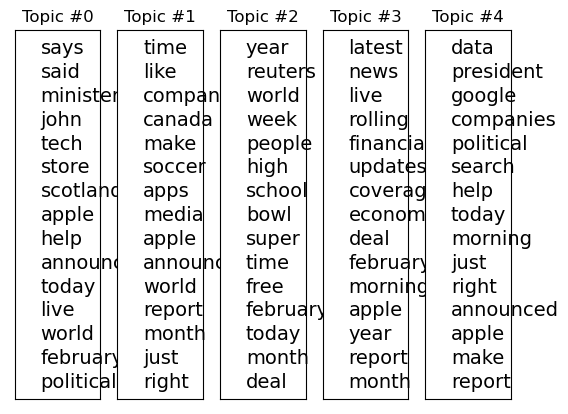

In [42]:
##############################################
##
##   LDA Topics Modeling
##
##
#########################################################
NUM_TOPICS=5
# = NUM_TOPICS

lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=100, learning_method='online')
#lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')
   
lda_Z_DF = lda_model.fit_transform(My_Orig_DF)
print(lda_Z_DF.shape)  # (NO_DOCUMENTS, NO_TOPICS)

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                    for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(lda_model, MyCountV)

############## Fancy Plot.................
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis.sklearn as LDAvis
import pyLDAvis

# ## conda install -c conda-forge pyldavis
pyLDAvis.enable_notebook() ## not using notebook
panel = LDAvis.prepare(lda_model, MyDTM, MyCountV,  mds='tsne')
pyLDAvis.save_html(panel, "InTheNews.html")

################ Another fun vis for LDA

word_topic = np.array(lda_model.components_)
#print(word_topic)
word_topic = word_topic.transpose()

num_top_words = 15
vocab_array = np.asarray(ColumnNames)

#fontsize_base = 70 / np.max(word_topic) # font size for word with largest share in corpus
fontsize_base = 14

for t in range(NUM_TOPICS):
    plt.subplot(1, NUM_TOPICS, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t))
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=fontsize_base)
                 ##fontsize_base*share)

#plt.tight_layout()
#plt.show()
plt.savefig("TopicsVis.pdf")

